References: \
https://qiskit-community.github.io/qiskit-machine-learning/tutorials/02_neural_network_classifier_and_regressor.html \
https://github.com/qiskit-community/qiskit-machine-learning/tree/main/qiskit_machine_learning \
https://github.com/Qiskit/qiskit/tree/main/qiskit

In [13]:
import torch
from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS
from torch import cat, no_grad, manual_seed
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms

import cv2
import math

import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
import qiskit_algorithms
from qiskit_algorithms.optimizers import COBYLA, SPSA, GradientDescent
from qiskit_aer import Aer, AerSimulator
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.utils import algorithm_globals
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_distribution

from qiskit_ibm_runtime import (
    QiskitRuntimeService, 
    EstimatorV2 as Estimator,
    SamplerV2 as Sampler,
)
from qiskit.primitives import (
    StatevectorSampler,
    BackendSampler as BackendSampler,
    BackendSamplerV2 as BackendSamplerV2,
)

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN

# Set seed for random generators
algorithm_globals.random_seed = 42

In [14]:
#Training Dataset
# Set train shuffle seed (for reproducibility)
manual_seed(42)
num_classes = 3
# Perfect square number of qubits
num_qubits = 9
img_dim = int(math.sqrt(num_qubits))
# Samples per class
training_samples = 75
test_samples = 25

# Use pre-defined torchvision function to load MNIST train data
full_training_data = datasets.MNIST(
    root="./data", train=True, download=True, transform=transforms.Compose([transforms.Resize((img_dim, img_dim)),
                                                                            transforms.ToTensor()])
)

subset = []
for i in range(num_classes):
    idx = np.where(full_training_data.targets == i)[0][:training_samples]
    subset.extend(idx)

train = datasets.MNIST(
    root="./data", train=True, download=True, transform=transforms.Compose([transforms.Resize((img_dim, img_dim)),
                                                                             transforms.ToTensor()])
)

train.data = full_training_data.data[subset]
train.targets = full_training_data.targets[subset]

test = datasets.MNIST(
    root="./data", train=False, download=True, transform=transforms.Compose([transforms.Resize((img_dim, img_dim)),
                                                                             transforms.ToTensor()])
)

subset = []
for i in range(num_classes):
    idx = np.where(full_training_data.targets == i)[0][:test_samples]
    subset.extend(idx)
    
test.data = full_training_data.data[subset]
test.targets = full_training_data.targets[subset]

print("Train subset size:", len(train))
# print("Valid subset size:", len(valid))
print("Test subset size:", len(test))

def count(dataset):
    counter = {}
    features = []
    labels = []
    imgs = []
    for i in range(len(dataset)):
        im, class_idx = dataset[i]
        imgs.append(im)
        features.append(np.reshape(im, -1))
        one_hot = np.eye(num_classes)[class_idx]
        labels.append(one_hot)
        if class_idx not in counter:
            counter[class_idx] = 0
        counter[class_idx] += 1
    counter = dict(sorted(counter.items(), key=lambda x: x[0]))

    for key, value in counter.items():
        print(key, ":", value)
    return np.array(features), np.array(labels), np.array(imgs)
        
print("Training Dataset")
train_feats, train_labels, train_imgs = count(train)
indices = np.arange(train_feats.shape[0])
np.random.shuffle(indices)
train_feats = train_feats[indices]
train_labels = train_labels[indices]
train_imgs = train_imgs[indices]

print(train_feats.shape)
print(train_labels.shape)
print("\n")

print("Testing Dataset")
test_feats, test_labels, test_imgs = count(test)
indices = np.arange(test_feats.shape[0])
np.random.shuffle(indices)
test_feats = test_feats[indices]
test_labels = test_labels[indices]
test_imgs = test_imgs[indices]

print(test_feats.shape)
print(test_labels.shape)

Train subset size: 225
Test subset size: 75
Training Dataset
0 : 75
1 : 75
2 : 75
(225, 9)
(225, 3)


Testing Dataset
0 : 25
1 : 25
2 : 25
(75, 9)
(75, 3)


The training dataset has 225 images
After the shuffle the 0th image has class index 1
(3, 3, 1)
Image shape is (3, 3, 1)


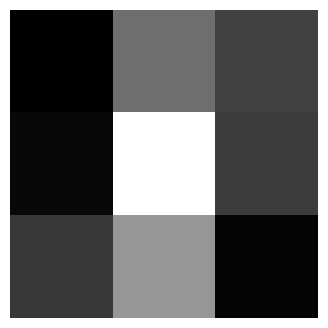

After the shuffle the 0th image has class index 0
(3, 3, 1)
Image shape is (3, 3, 1)


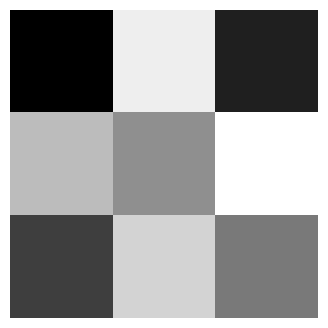

After the shuffle the 0th image has class index 2
(3, 3, 1)
Image shape is (3, 3, 1)


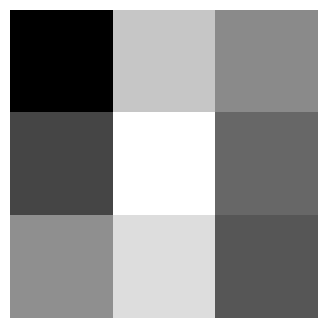

In [15]:
'''
Explore the constructed dataset
'''
import random
import matplotlib.pyplot as plt

# Find and output the number of images
n = len(train)
print(f'The training dataset has {n} images')

for i in range(3):
    # Randomly shuffle the image indices
    indices = list(range(n))
    random.shuffle(indices)

    # Get the image and the class id of the 0th image after the shuffle.
    im, class_idx = train[indices[0]]
    
    print(f'After the shuffle the 0th image has class index {class_idx}')

    # Convert the image from an array back to a numpy 3d array
    im_np = im.numpy().transpose((1, 2, 0))
    print(im_np.shape)
    print(f'Image shape is {im_np.shape}')

    # Display the image
    plt.imshow(im_np, cmap='gray')
    plt.axis('off')
    plt.show()

In [16]:
service = QiskitRuntimeService()
backend = service.backend("ibm_rensselaer")
fake_backend = AerSimulator.from_backend(backend)
print(backend)

num_qubits = len(train_feats[0])
print(num_qubits)

<IBMBackend('ibm_rensselaer')>
9


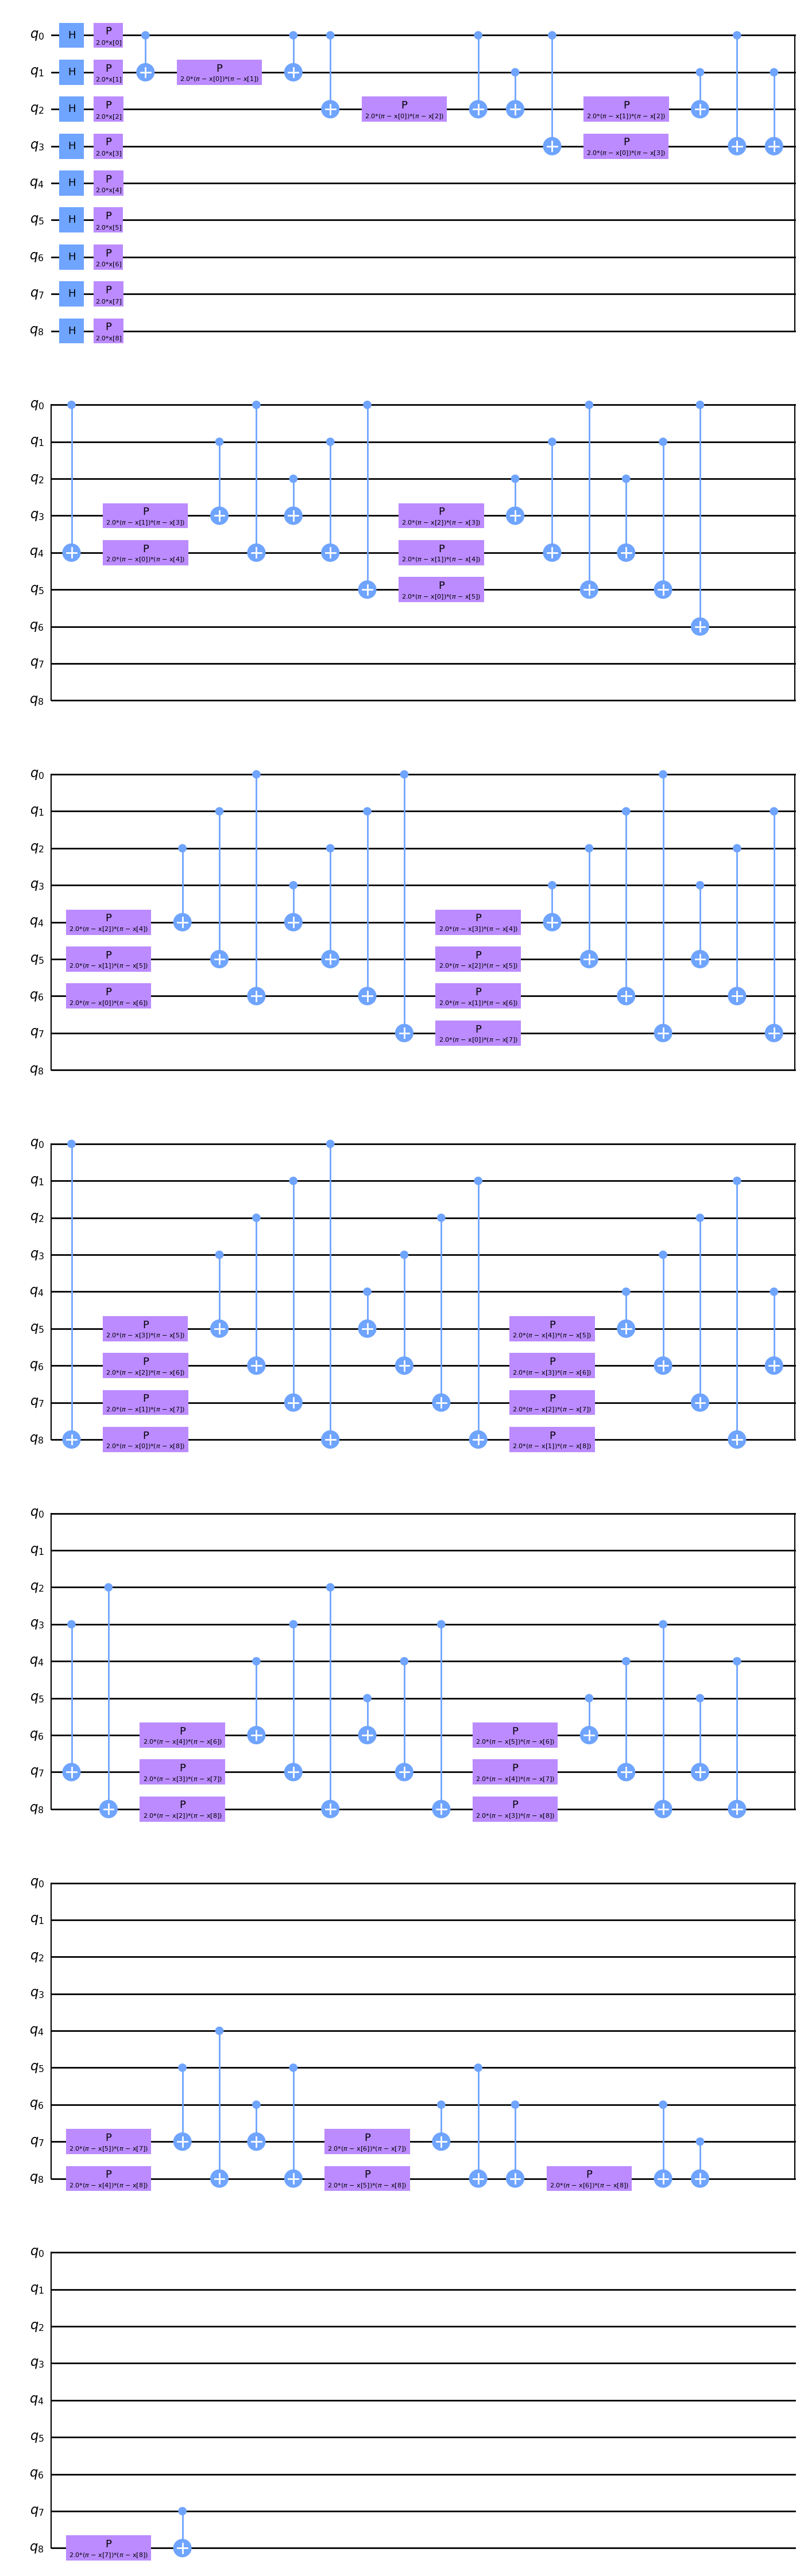

In [17]:
feature_map = ZZFeatureMap(feature_dimension=num_qubits, reps=1)
feature_map.decompose().draw(output="mpl", style="clifford", fold=20)

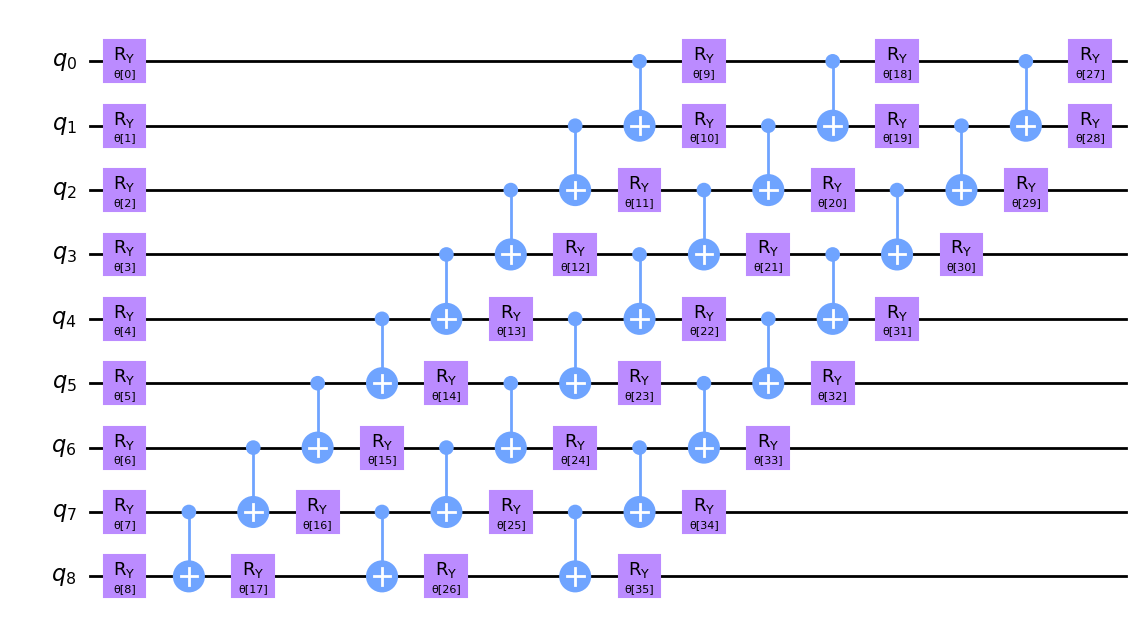

In [18]:
ansatz = RealAmplitudes(num_qubits=num_qubits, reps=3)
ansatz.decompose().draw(output="mpl", style="clifford", fold=20)

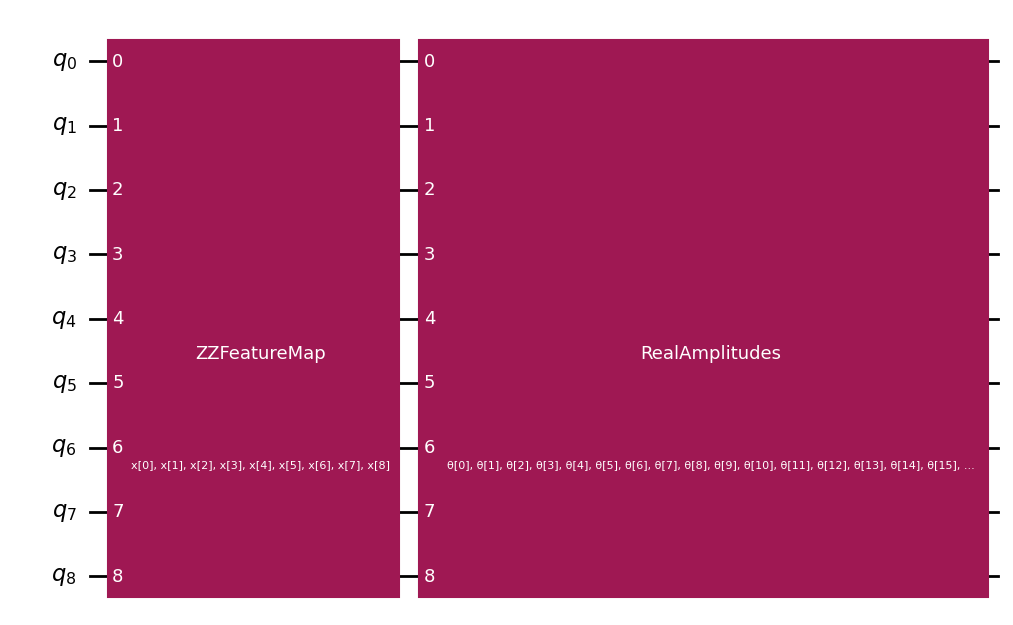

In [19]:
circuit = QuantumCircuit(num_qubits)
circuit.compose(feature_map, inplace=True)
circuit.compose(ansatz, inplace=True)
circuit.draw('mpl')

In [20]:
def parity(x):
    return "{:b}".format(x).count("1") % num_classes
    
sampler = BackendSampler(backend=fake_backend)

sampler_qnn = SamplerQNN(
    circuit=circuit,
    sampler=sampler,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    interpret=parity,
    output_shape=num_classes,
)

sampler_qnn_input = algorithm_globals.random.random(sampler_qnn.num_inputs)
sampler_qnn_weights = algorithm_globals.random.random(sampler_qnn.num_weights)

sampler_qnn_forward = sampler_qnn.forward(sampler_qnn_input, sampler_qnn_weights)
print(sampler_qnn_forward)

C:\Users\Chris\AppData\Local\Temp\ipykernel_28460\1699821699.py:4: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler = BackendSampler(backend=fake_backend)


[[0.33984375 0.32617188 0.33398438]]


In [21]:
from IPython.display import clear_output

def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Loss against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

initial_weights = 2 * np.pi * algorithm_globals.random.random(ansatz.num_parameters)
print(f"Initial weights: {initial_weights}")

classifier = NeuralNetworkClassifier(
    neural_network=sampler_qnn,
    loss="cross_entropy",
    one_hot=True,
    optimizer=SPSA(maxiter=30, learning_rate=0.001, perturbation=0.001),
    initial_point=initial_weights,
    callback=callback_graph
)

Initial weights: [5.05648359 2.43459846 1.81161891 4.28824572 0.87809075 1.25606028
 0.04625851 4.94439169 4.17738113 4.43068475 4.90546518 2.88345286
 3.57350633 0.87837044 0.71961368 4.19969967 2.95998476 3.5514832
 4.80662958 3.98805282 3.47824196 3.51360222 1.90977479 0.19363417
 2.74397628 1.34827526 2.56686117 5.36208965 1.46988514 0.36632693
 1.76798714 1.84470399 4.15894412 3.49993624 4.92537771 4.17400508]


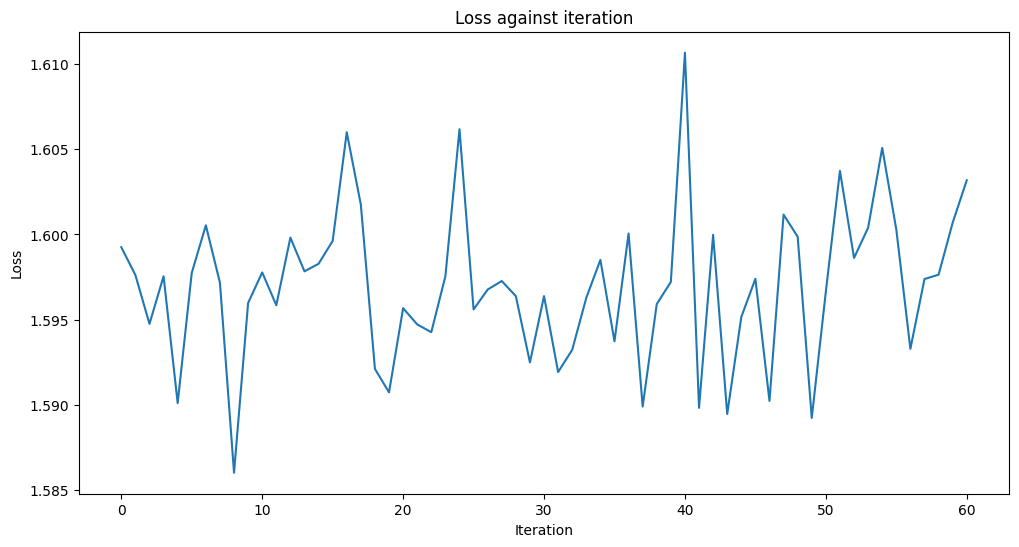

Training time: 1513 seconds


In [22]:
import time

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
start = time.time()
classifier.fit(train_feats, train_labels)
elapsed = time.time() - start

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

print(f"Training time: {round(elapsed)} seconds")
print("Losses:", objective_func_vals)

In [23]:
start = time.time()
accuracy = classifier.score(test_feats, test_labels)
elapsed = time.time() - start

print(f"Testing time: {round(elapsed)} seconds")
print(f"Accuracy: {accuracy}")
print(f"Trained weights: {classifier.weights}")

Testing time: 9 seconds
Accuracy: 0.32
Trained weights: [5.03512315 2.43931028 1.80593856 4.26976533 0.85167419 1.27034932
 0.02928138 4.96307027 4.17091623 4.39416155 4.90781943 2.88642877
 3.59301182 0.8608315  0.7211677  4.22087538 2.95371036 3.56828334
 4.78853419 3.984437   3.5086386  3.50838075 1.92054001 0.23918846
 2.71809406 1.3423505  2.55764444 5.36378086 1.49232429 0.37257611
 1.78985904 1.82327186 4.14184898 3.53421893 4.91600064 4.22114816]


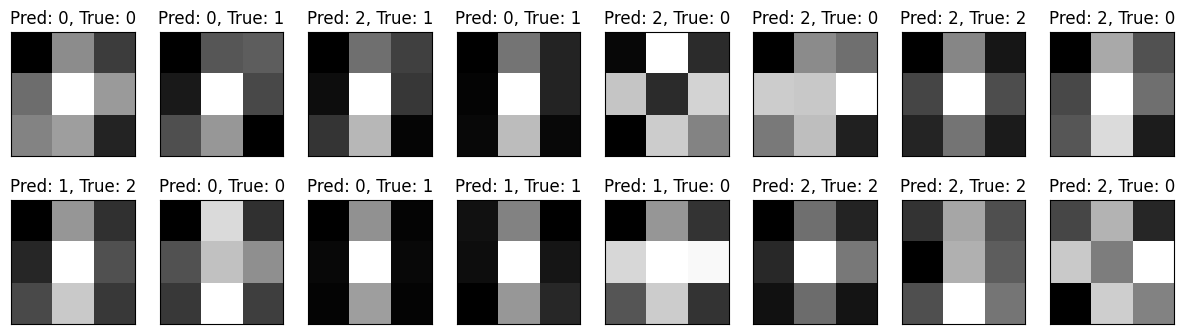

In [24]:
test_pred = classifier.predict(test_feats)

# Plot predicted labels
n_samples_show = 8
n_rows = 2
count = 0
fig, axes = plt.subplots(nrows=n_rows, ncols=n_samples_show, figsize=(15, 4))
for img, true, output in zip(test_imgs, test_labels, test_pred):
    if count == n_samples_show * n_rows:
        break
    
    pred = np.argmax(output)
    gt = np.argmax(true)
    row = count // n_samples_show  # Calculate row index
    col = count % n_samples_show  # Calculate column index

    im_np = img.transpose((1, 2, 0))
    axes[row, col].imshow(im_np, cmap="gray")

    axes[row, col].set_xticks([])
    axes[row, col].set_yticks([])
    axes[row, col].set_title("Pred: {}, True: {}".format(pred, gt))

    count += 1